In [1]:
!pip install tensorflow scikit-learn shap


In [2]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model


# 'group' is the last column
data = pd.read_csv("to_clustr.csv")

In [5]:
# Split predictors (X) and target (y)
X = data.iloc[:, :-1].values
y = data['group'].values


In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Standardize the predictors
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:

def build_model(hp):
    model = Sequential()

    # First layer: tune number of units and activation function
    model.add(Dense(
        units=hp.Int('units_layer_1', min_value=32, max_value=128, step=32),
        activation=hp.Choice('activation_layer_1', values=['relu', 'tanh']),
        input_dim=X_train.shape[1]  # Input layer shape
    ))

    # Add a tunable number of additional hidden layers
    for i in range(hp.Int('num_hidden_layers', 1, 4)):  # Number of hidden layers between 1 and 10
        model.add(Dense(
            units=hp.Int(f'units_layer_{i+2}', min_value=16, max_value=128, step=16),
            activation=hp.Choice(f'activation_layer_{i+2}', values=['relu', 'tanh'])
        ))

    # Output layer (fixed)
    model.add(Dense(1, activation='sigmoid'))

    # Tune learning rate for Adam optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [9]:

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Run each configuration once
    directory='my_dir',  # Directory to save results
    project_name='hyperparameter_tuning'
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Start the search
tuner.search(X_train, y_train, epochs=100, validation_split=0.2, verbose=1, batch_size=32)


Trial 10 Complete [00h 00m 38s]
val_accuracy: 0.6814814805984497

Best val_accuracy So Far: 0.7066666483879089
Total elapsed time: 00h 06m 13s


In [11]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first hidden layer is {best_hps.get('units_layer_1')}
with {best_hps.get('activation_layer_1')} activation.
The optimal number of units in the second hidden layer is {best_hps.get('units_layer_2')}
with {best_hps.get('activation_layer_2')} activation.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The optimal number of units in the first hidden layer is 64 
with tanh activation.
The optimal number of units in the second hidden layer is 16 
with tanh activation.
The optimal learning rate for the optimizer is 0.0001.



In [12]:
# Build the model with the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

# Train the final model
final_model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1, batch_size=32)

# Evaluate the model on the test set
loss, accuracy = final_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5456 - loss: 0.6902 - val_accuracy: 0.5941 - val_loss: 0.6726
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6104 - loss: 0.6680 - val_accuracy: 0.6178 - val_loss: 0.6590
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6282 - loss: 0.6561 - val_accuracy: 0.6326 - val_loss: 0.6488
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6322 - loss: 0.6455 - val_accuracy: 0.6415 - val_loss: 0.6409
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6604 - loss: 0.6327 - val_accuracy: 0.6681 - val_loss: 0.6347
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6781 - loss: 0.6239 - val_accuracy: 0.6667 - val_loss: 0.6287
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6780 - loss: 0.6198 - val_accuracy: 0.6696 - val_loss: 0.6244
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6789 - loss: 0.6185 - val_accuracy: 0.6711 - v

In [13]:
# Evaluate on test data
loss, accuracy = final_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6527 - loss: 0.6564 
Test Accuracy: 0.63


PermutationExplainer explainer: 845it [01:05, 11.76it/s]


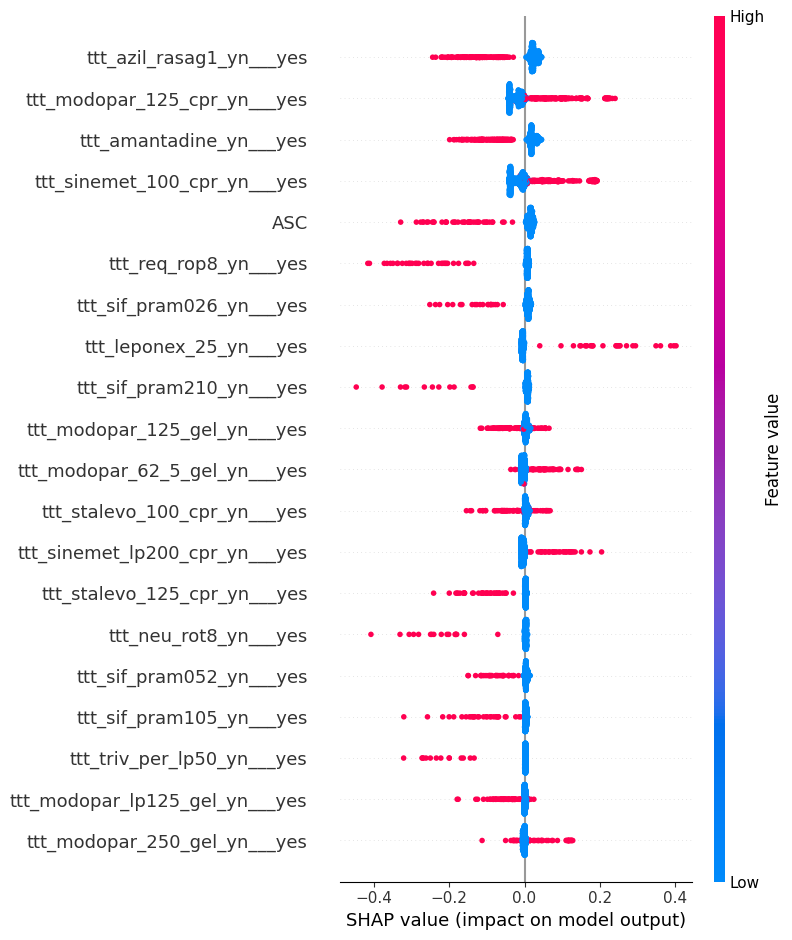

In [14]:
import shap

# Explain the predictions using SHAP
explainer = shap.Explainer(final_model, X_train)
shap_values = explainer(X_test)

# Plot the summary of feature importance
shap.summary_plot(shap_values, X_test, feature_names=data.columns[:-1])

In [15]:
help(shap.summary_plot)

Help on function summary_legacy in module shap.plots._beeswarm:

summary_legacy(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7fb64acfc4f0>, show_values_in_legend=False, use_log_scale=False)
    Create a SHAP beeswarm plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    
    feature

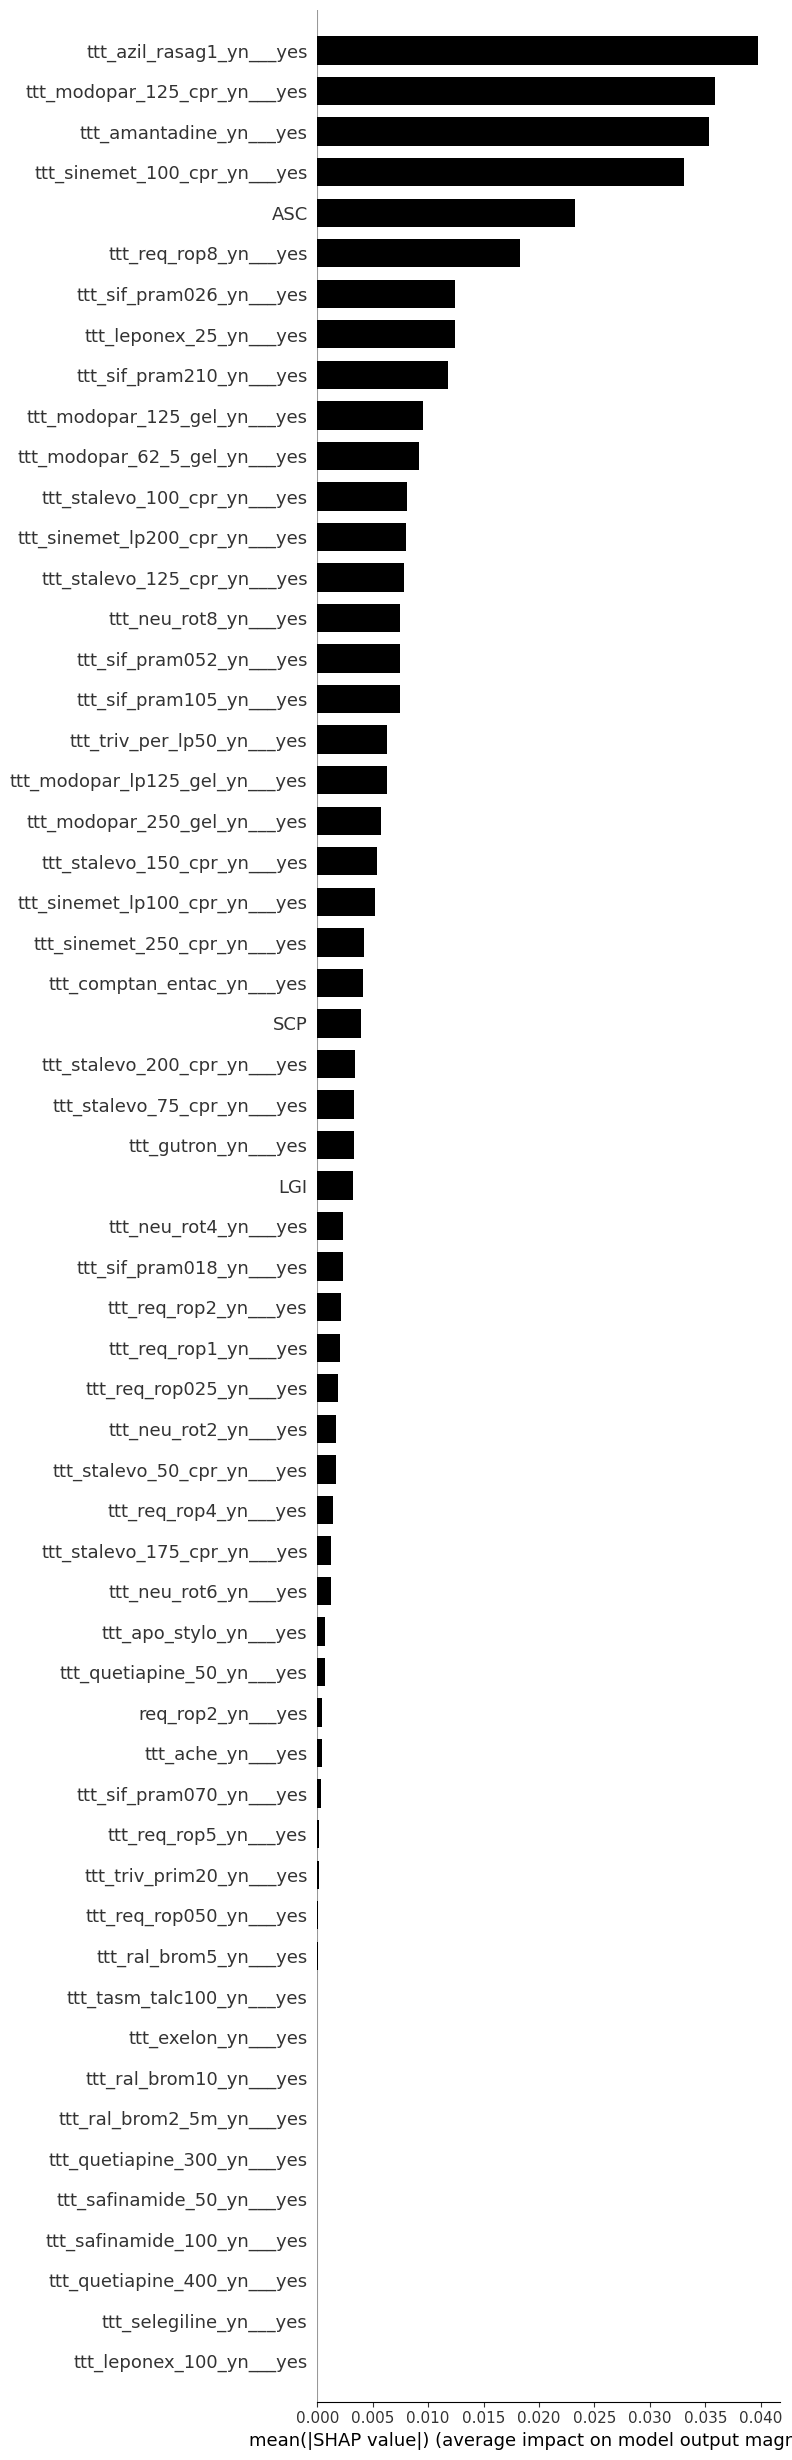

In [16]:
# Bar plot of mean absolute SHAP values
shap.summary_plot(shap_values, X_test, max_display=60, feature_names=data.columns[:-1], plot_type='bar', color="black")


In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_pred_proba = final_model.predict(X_test).ravel()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.2f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
AUC: 0.67


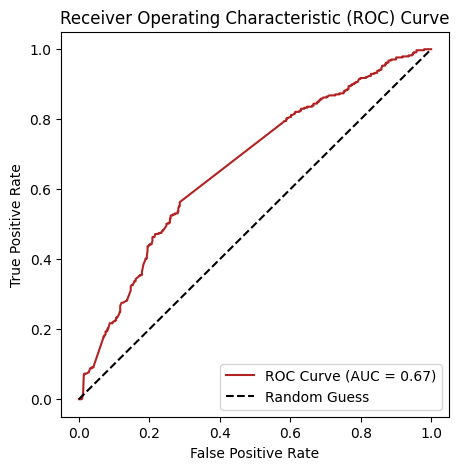

In [20]:
# Plot the ROC Curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", color='firebrick')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")  # Dashed diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


In [21]:
print("Training set class distribution:", np.bincount(y_train))
print("Test set class distribution:", np.bincount(y_test))

Training set class distribution: [2187 1185]
Test set class distribution: [503 341]


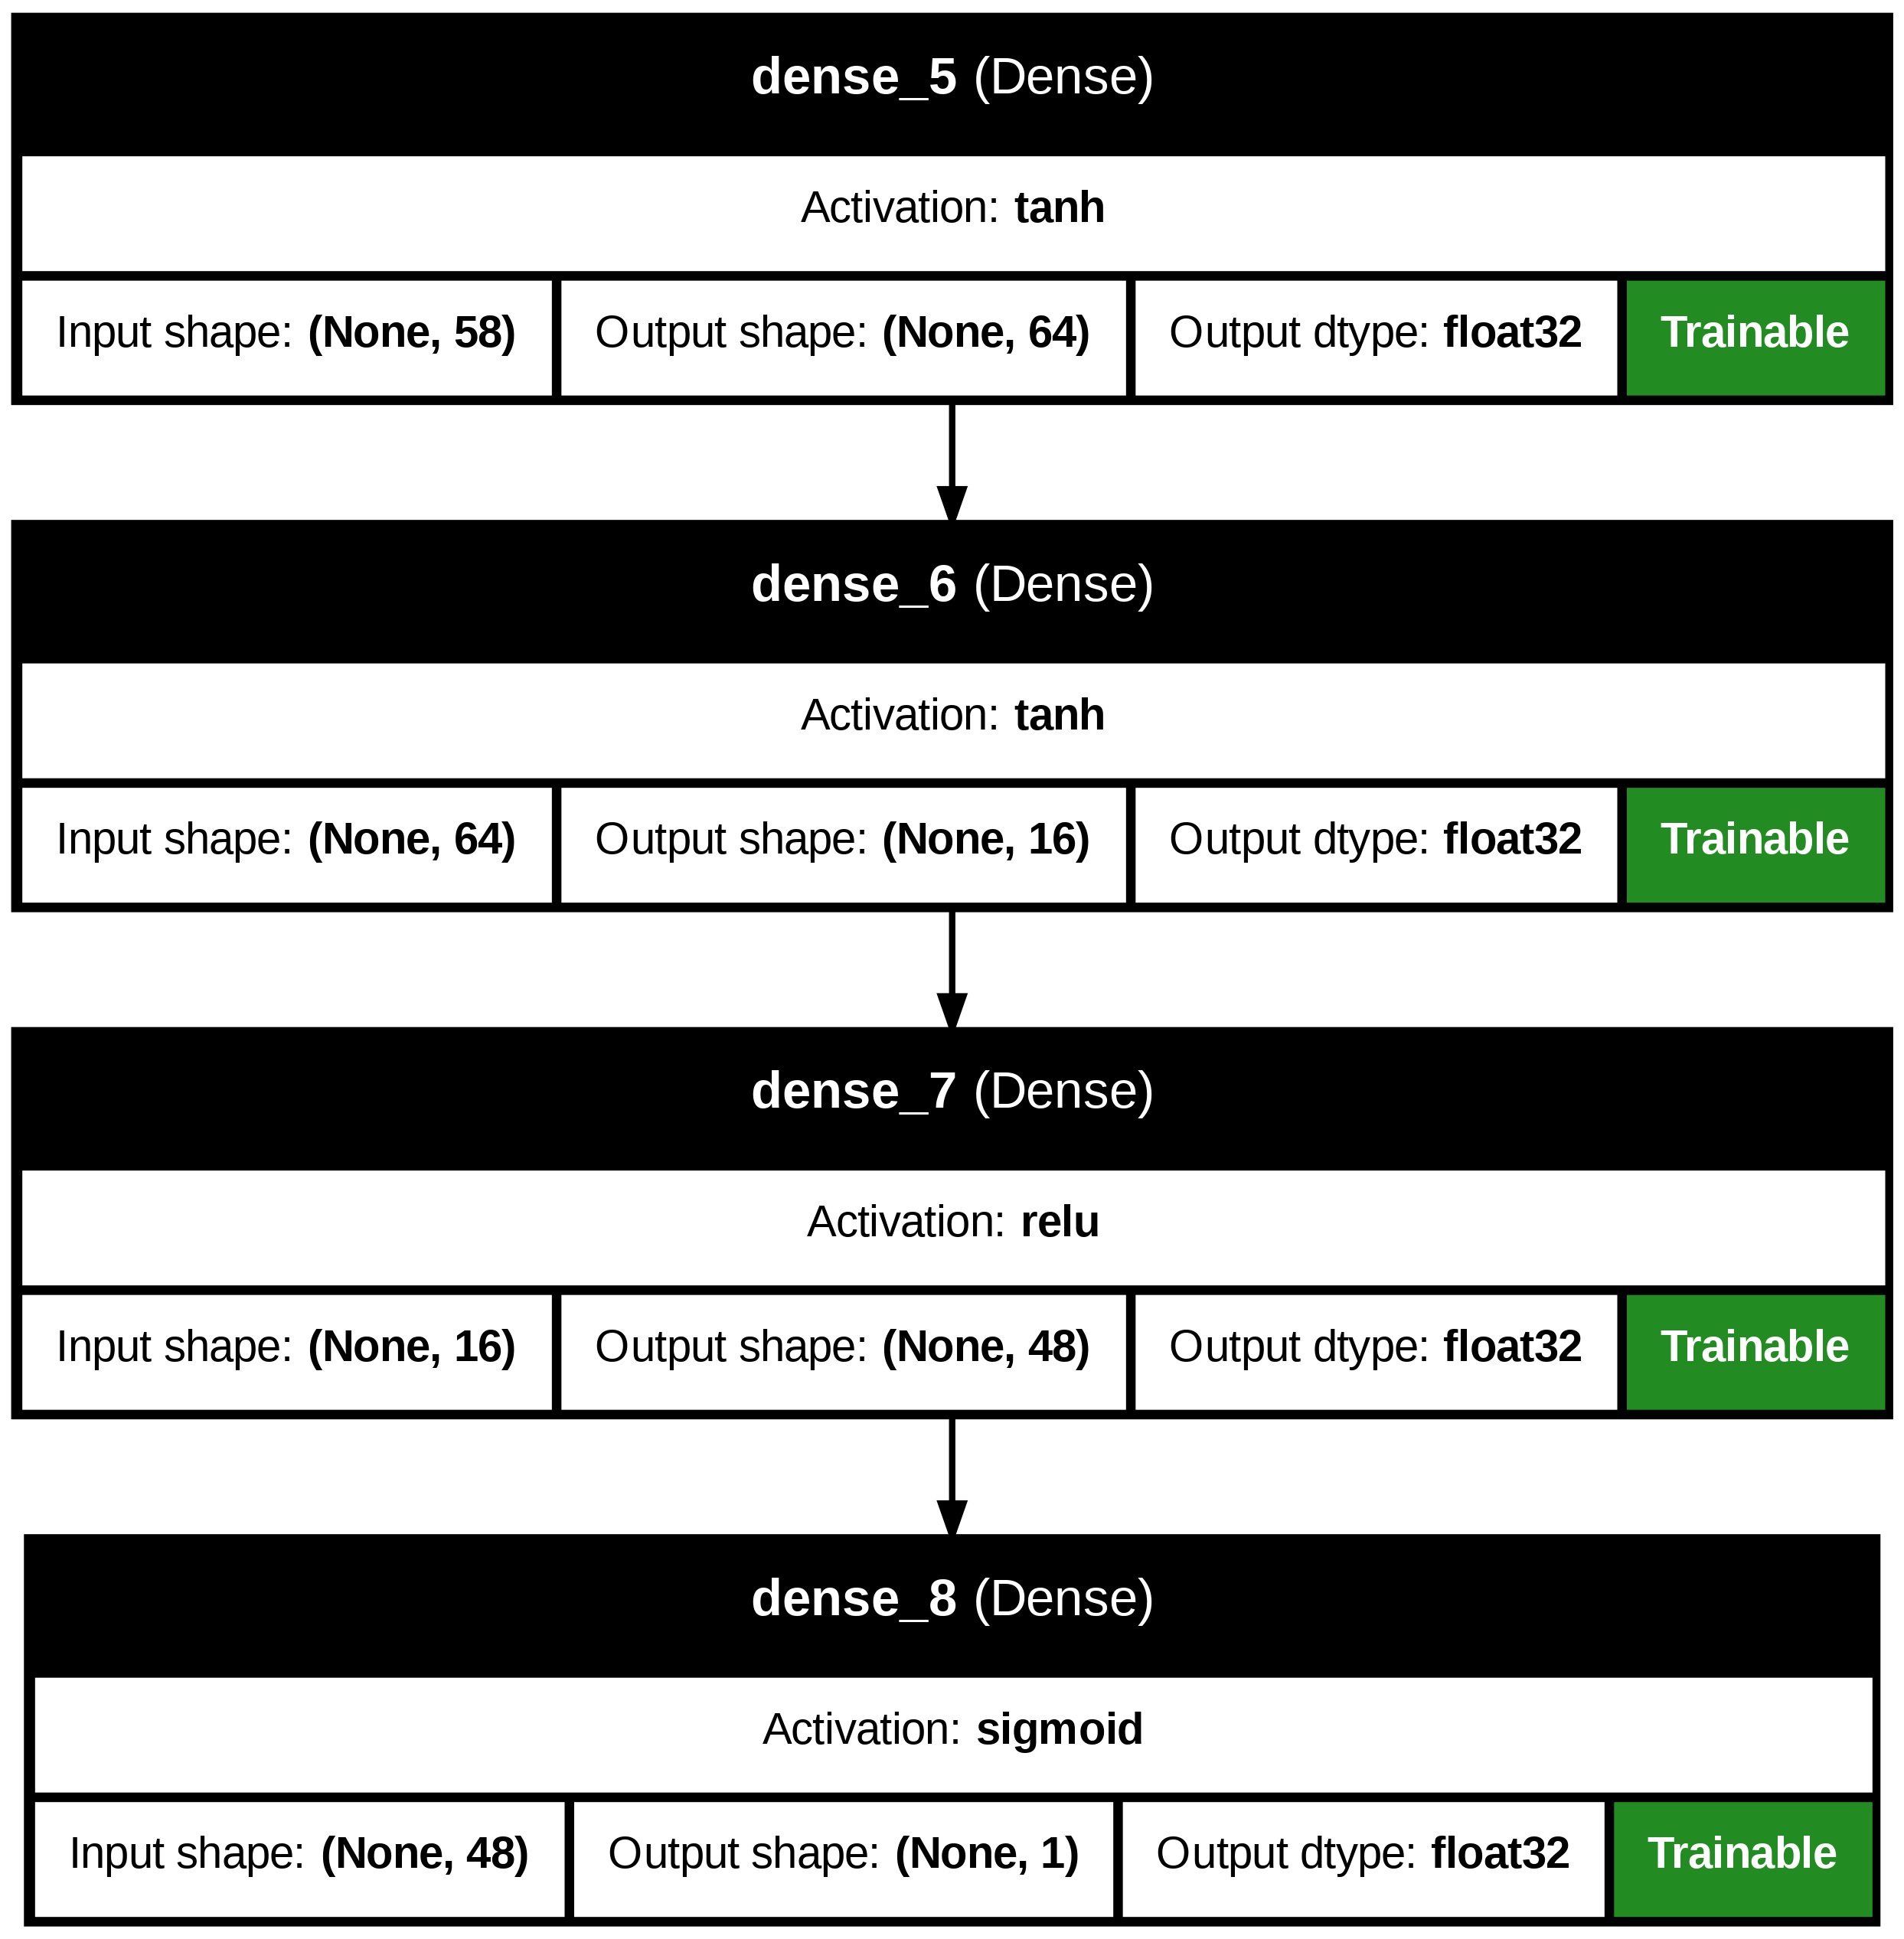

In [22]:
plot_model(final_model, to_file='model_architecture.png',
           show_shapes=True, show_layer_names=True, expand_nested=True,
            show_dtype=True, show_layer_activations=True, show_trainable=True,
           rankdir='TB', dpi=300)

In [23]:
# Group by 'group' and 'ttt_azil_rasag1_yn___yes', then calculate count

#ttt_modopar_125_cpr_yn___yes
#ttt_azil_rasag1_yn___yes
#ttt_amantadine_yn___yes
#ttt_sinemet_100_cpr_yn___yes
#ASC

grouped_counts = data.groupby(['group', 'ttt_modopar_125_cpr_yn___yes']).size().reset_index(name='count')
# Calculate the total count for each group
total_counts = data.groupby('group').size().reset_index(name='total_count')
# Merge total counts back to the grouped counts to calculate percentages
grouped_counts = pd.merge(grouped_counts, total_counts, on='group')
# Calculate percentage
grouped_counts['percentage'] = (grouped_counts['count'] / grouped_counts['total_count']) * 100
# Drop the 'total_count' column if it's no longer needed
grouped_counts = grouped_counts.drop(columns=['total_count'])
# Print the results
print(grouped_counts)

grouped_counts = data.groupby(['group', 'ttt_azil_rasag1_yn___yes']).size().reset_index(name='count')
# Calculate the total count for each group
total_counts = data.groupby('group').size().reset_index(name='total_count')
# Merge total counts back to the grouped counts to calculate percentages
grouped_counts = pd.merge(grouped_counts, total_counts, on='group')
# Calculate percentage
grouped_counts['percentage'] = (grouped_counts['count'] / grouped_counts['total_count']) * 100
# Drop the 'total_count' column if it's no longer needed
grouped_counts = grouped_counts.drop(columns=['total_count'])
# Print the results
print(grouped_counts)

grouped_counts = data.groupby(['group', 'ttt_amantadine_yn___yes']).size().reset_index(name='count')
# Calculate the total count for each group
total_counts = data.groupby('group').size().reset_index(name='total_count')
# Merge total counts back to the grouped counts to calculate percentages
grouped_counts = pd.merge(grouped_counts, total_counts, on='group')
# Calculate percentage
grouped_counts['percentage'] = (grouped_counts['count'] / grouped_counts['total_count']) * 100
# Drop the 'total_count' column if it's no longer needed
grouped_counts = grouped_counts.drop(columns=['total_count'])
# Print the results
print(grouped_counts)

grouped_counts = data.groupby(['group', 'ttt_sinemet_100_cpr_yn___yes']).size().reset_index(name='count')
# Calculate the total count for each group
total_counts = data.groupby('group').size().reset_index(name='total_count')
# Merge total counts back to the grouped counts to calculate percentages
grouped_counts = pd.merge(grouped_counts, total_counts, on='group')
# Calculate percentage
grouped_counts['percentage'] = (grouped_counts['count'] / grouped_counts['total_count']) * 100
# Drop the 'total_count' column if it's no longer needed
grouped_counts = grouped_counts.drop(columns=['total_count'])
# Print the results
print(grouped_counts)

grouped_counts = data.groupby(['group', 'ASC']).size().reset_index(name='count')
# Calculate the total count for each group
total_counts = data.groupby('group').size().reset_index(name='total_count')
# Merge total counts back to the grouped counts to calculate percentages
grouped_counts = pd.merge(grouped_counts, total_counts, on='group')
# Calculate percentage
grouped_counts['percentage'] = (grouped_counts['count'] / grouped_counts['total_count']) * 100
# Drop the 'total_count' column if it's no longer needed
grouped_counts = grouped_counts.drop(columns=['total_count'])
# Print the results
print(grouped_counts)

   group  ttt_modopar_125_cpr_yn___yes  count  percentage
0      0                             0   2191   81.449814
1      0                             1    499   18.550186
2      1                             0   1188   77.850590
3      1                             1    338   22.149410
   group  ttt_azil_rasag1_yn___yes  count  percentage
0      0                         0   2179   81.003717
1      0                         1    511   18.996283
2      1                         0   1419   92.988204
3      1                         1    107    7.011796
   group  ttt_amantadine_yn___yes  count  percentage
0      0                        0   2151   79.962825
1      0                        1    539   20.037175
2      1                        0   1341   87.876802
3      1                        1    185   12.123198
   group  ttt_sinemet_100_cpr_yn___yes  count  percentage
0      0                             0   2214   82.304833
1      0                             1    476   17.695167
2

In [26]:

grouped_counts = data.groupby(['group', 'ttt_quetiapine_300_yn___yes']).size().reset_index(name='count')
# Calculate the total count for each group
total_counts = data.groupby('group').size().reset_index(name='total_count')
# Merge total counts back to the grouped counts to calculate percentages
grouped_counts = pd.merge(grouped_counts, total_counts, on='group')
# Calculate percentage
grouped_counts['percentage'] = (grouped_counts['count'] / grouped_counts['total_count']) * 100
# Drop the 'total_count' column if it's no longer needed
grouped_counts = grouped_counts.drop(columns=['total_count'])
# Print the results
print(grouped_counts)

   group  ttt_quetiapine_300_yn___yes  count  percentage
0      0                            0   2690       100.0
1      1                            0   1526       100.0


In [ ]:
d